In [1]:
import numpy as np
from qutip import *
import matplotlib.pyplot as plt
from mpmath import *
from qutip.solver.nonmarkov.transfertensor import ttmsolve
from scipy.ndimage import gaussian_filter1d

In [2]:
lam = 0.1
gamma_0 = 0.5

def Expr(t):
    l = np.emath.sqrt(lam**2 - 2*gamma_0*lam)

    expression = ((-l**2 + lam**2)*np.sinh(l*t/2))/(l*np.cosh(l*t/2) + lam*np.sinh(l*t/2))

    return expression



def s(t):
    return np.imag(Expr(t))

#Define Hamiltonian

H0 = sigmam()*sigmap()

# Define gammma(t)

# def gam(t):
#     if np.real(Expr(t)) < 0 :
#         return np.sqrt(complex(np.real(Expr(t))))
#     else:
#         return np.sqrt(np.real(Expr(t)))       #np.sqrt(np.real(Expr(t)))

# def gam(t):
#     return np.abs(np.real(Expr(t)))
def gam(t):
    return np.real(Expr(t))


time = np.linspace(0.1, 100, 2000000)  # Adjust time range as needed

# Trying to smoothen  gamma values
gam_vals = np.array([gam(t) for t in time])

def smoothen_gamma(gamma_vals, sigma=2):
    """
    Smoothen the gamma(t) values using a Gaussian filter.

    Parameters:
    gamma_vals (np.array): The input array of gamma(t) values.
    sigma (float): The standard deviation for Gaussian kernel. Higher values result in more smoothing.
    
    Returns:
    np.array: The smoothened gamma(t) array.
    """
    # Apply Gaussian filter for smoothing
    smoothened_gamma = gaussian_filter1d(gamma_vals, 3)
    return smoothened_gamma

gam_vals_new = smoothen_gamma(gam_vals)



<>:6: SyntaxWarning: invalid escape sequence '\g'
<>:6: SyntaxWarning: invalid escape sequence '\g'
<>:6: SyntaxWarning: invalid escape sequence '\g'
<>:6: SyntaxWarning: invalid escape sequence '\g'
C:\Users\DELL\AppData\Local\Temp\ipykernel_17896\2974414707.py:6: SyntaxWarning: invalid escape sequence '\g'
  plt.title(f"Time Evolution of $\gamma(t)$ \n$\lambda$: {lam}, $\gamma_0$: {gamma_0}", fontsize=18, pad=20)
C:\Users\DELL\AppData\Local\Temp\ipykernel_17896\2974414707.py:6: SyntaxWarning: invalid escape sequence '\g'
  plt.title(f"Time Evolution of $\gamma(t)$ \n$\lambda$: {lam}, $\gamma_0$: {gamma_0}", fontsize=18, pad=20)


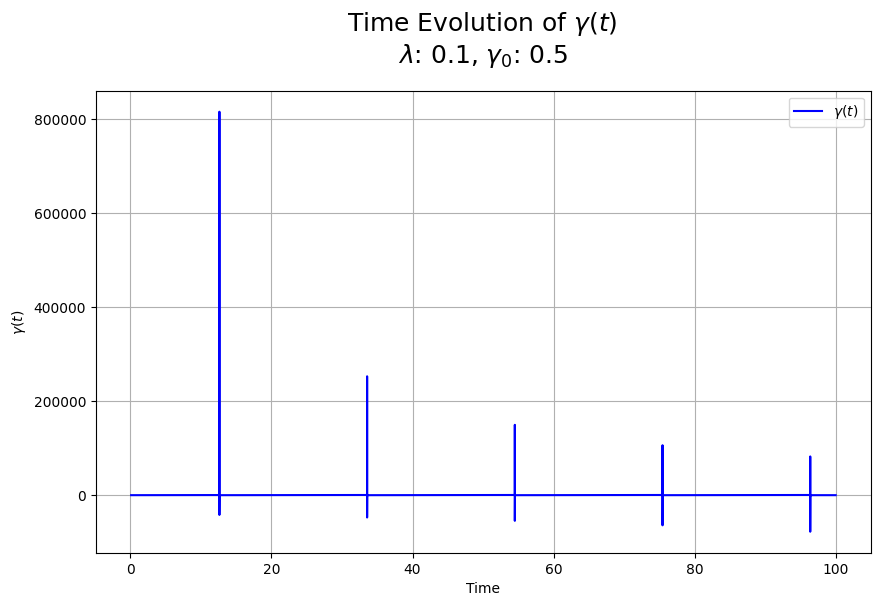

In [3]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time, gam_vals, label=r'$\gamma(t)$', color='b')
plt.xlabel('Time')
plt.ylabel(r'$\gamma(t)$')
plt.title(f"Time Evolution of $\gamma(t)$ \n$\lambda$: {lam}, $\gamma_0$: {gamma_0}", fontsize=18, pad=20)
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# nmmc_options = {"map": "parallel",
#                 "norm_steps": 10}  # options specific to nm_mcsolve
# options = {"progress_bar": "enhanced"}  # options shared by all solvers
# ntraj = 5500
# #Define Hamiltonian

H0 = sigmam() * sigmap()

H = [H0,s]

ops_and_rates = [[sigmap(),gam_vals_new]]  # time-dependent collapse term


#s(10,args)
# times = time = np.linspace(0.1, 2000, 1000)  #np.linspace(0.1,100, 100)

psi0 = (basis(2, 0) + basis(2, 1)).unit() 

# Define zero Hamiltonian
H_zero = Qobj(np.zeros((2, 2)))  # Zero operator for the Hamiltonian

e_ops = [sigmax(), sigmay(), sigmaz()]

# Increase the nsteps parameter in the Options class
options = Options(store_states=True, nsteps=50000, atol=1e-8, rtol=1e-6)

# options = {"progress_bar": "enhanced"}  # options shared by all solvers
ntraj = 5500

nmmc_options = {
    "map": "parallel",
    "norm_steps": 10,
}

result2 = nm_mcsolve(H_zero, psi0, time, ops_and_rates, e_ops, options=options)   #(options | nmmc_options)
# result2 = nm_mcsolve(QobjEvo([H,s]), 
#                      psi0, 
#                      times, 
#                      ops_and_rates, 
#                      e_ops,
#                      ntraj=2500, options=options)

# solver = NonMarkovianMCSolver(H_zero, 
#                      ops_and_rates, 
#                      options=(options | nmmc_options))

# result2 = solver.run(psi0, tlist=time, ntraj=ntraj, e_ops=e_ops)

# Solve using mesolve

c:\Users\DELL\anaconda3\envs\qiskit\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


10.0%. Run time: 17171.87s. Est. time left: 01:18:55:46
20.0%. Run time: 42628.90s. Est. time left: 01:23:21:55
30.0%. Run time: 83330.98s. Est. time left: 02:06:00:38
40.0%. Run time: 96969.86s. Est. time left: 01:16:24:14


In [ ]:
from qutip import Options

# Define custom options to resolve the trace deviation and other issues
nmmc_options = {
    "map": "parallel",  # Run in parallel for efficiency with large number of trajectories
    "norm_steps": 10,   # Normalize the state every 10 steps to help with trace deviations
}

# Options for the solver:
solver_options = Options(
    nsteps=500000,          # Increase the number of integration steps
    atol=1e-8,              # Set absolute tolerance for high precision
    rtol=1e-6,              # Set relative tolerance for high precision
    method="bdf",           # Use "bdf" solver for stiff equations, switch to "adams" if needed
    store_states=True,      # Store all states (useful for inspecting trace later)
    progress_bar="enhanced" # Enhanced progress bar to track progress
)

# Implement a manual trace normalization step in the NonMarkovianMCSolver loop:
def normalize_states(result):
    """Normalize the density matrix or state vector after each trajectory to ensure trace == 1"""
    for idx in range(len(result.states)):
        # Normalize the state for each time step
        state = result.states[idx]
        result.states[idx] = state / state.tr()
    return result


result2 = nm_mcsolve(H_zero, psi0, time, ops_and_rates, e_ops, ntraj, options=(solver_options | nmmc_options))



 Total run time: 155.36s*] Elapsed 154.45s / Remaining 00:00:00:00          1%           ] Elapsed 12.19s / Remaining 00:00:20:06[          1%           ] Elapsed 12.28s / Remaining 00:00:20:16[          2%           ] Elapsed 13.82s / Remaining 00:00:11:17[*         6%           ] Elapsed 19.73s / Remaining 00:00:05:09[***      12%           ] Elapsed 27.63s / Remaining 00:00:03:22[*****    23%           ] Elapsed 43.58s / Remaining 00:00:02:25[******   24%           ] Elapsed 44.61s / Remaining 00:00:02:21[******** 35%           ] Elapsed 61.50s / Remaining 00:00:01:54[*********40%           ] Elapsed 68.04s / Remaining 00:00:01:42[*********43%           ] Elapsed 72.27s / Remaining 00:00:01:35[*********47%           ] Elapsed 77.80s / Remaining 00:00:01:27[*********49%           ] Elapsed 80.30s / Remaining 00:00:01:23[*********58%*          ] Elapsed 91.59s / Remaining 00:00:01:06[*********64%***        ] Elapsed 100.62s / Remaining 00:00:00:56[*********70%****       ] Elapsed 108.

<>:14: SyntaxWarning: invalid escape sequence '\g'
<>:14: SyntaxWarning: invalid escape sequence '\g'
<>:14: SyntaxWarning: invalid escape sequence '\g'
<>:14: SyntaxWarning: invalid escape sequence '\g'
C:\Users\DELL\AppData\Local\Temp\ipykernel_12084\2465047056.py:14: SyntaxWarning: invalid escape sequence '\g'
  plt.title(f"Trace of state of $\gamma(t)$ \n$\lambda$: {lam}, $\gamma_0$: {gamma_0}", fontsize=18, pad=20)
C:\Users\DELL\AppData\Local\Temp\ipykernel_12084\2465047056.py:14: SyntaxWarning: invalid escape sequence '\g'
  plt.title(f"Trace of state of $\gamma(t)$ \n$\lambda$: {lam}, $\gamma_0$: {gamma_0}", fontsize=18, pad=20)


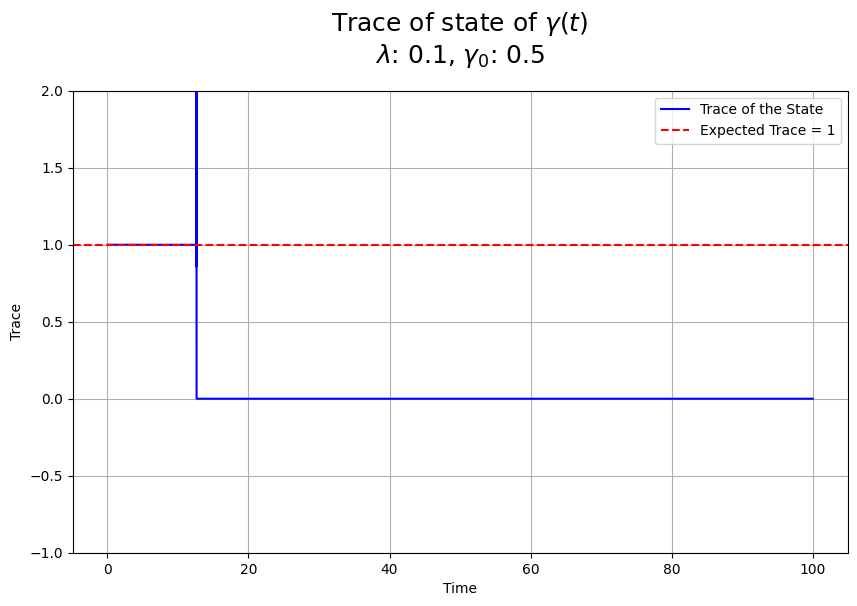

[0.9999999999999999, 1.0, 1.0, 0.9999999999999991, 1.0, 1.0, 1.0, 1.0000000000000002, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0000000000000002, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0000000000000036, 1.0, 1.0, 1.0, 1.0, 1.0000000000000002, 1.0, 1.0, 1.0000000000000002, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0000000000000036, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999999, 1.0, 1.0, 1.0, 1.0, 0.9999999999999998, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999999, 1.0, 1.0, 1.0000000000000002, 1.0, 1.0, 1.0, 1.0, 1.0000000000000002, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999999, 1.0000000000000002, 1.0, 1.0, 0.9999999999999998, 1.0, 1.0, 1.0, 0.9999999999999998, 0.9999999999999998, 1.0, 0.9999999999999998, 1.00

In [ ]:
# Extract the states from the result
states = result2.states  # This should contain the quantum states at each time step

# Calculate the trace for each state (assuming they are density matrices)
traces = [state.tr() for state in states]

# Prepare for plotting
plt.figure(figsize=(10, 6))
plt.plot(time, traces, label='Trace of the State', color='blue')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Trace')
plt.title(f"Trace of state of $\gamma(t)$ \n$\lambda$: {lam}, $\gamma_0$: {gamma_0}", fontsize=18, pad=20)
plt.ylim([-1, 2])

plt.axhline(y=1, color='r', linestyle='--', label='Expected Trace = 1')
plt.legend()
plt.grid()
plt.show()

print(traces)

<>:12: SyntaxWarning: invalid escape sequence '\l'
<>:12: SyntaxWarning: invalid escape sequence '\g'
<>:12: SyntaxWarning: invalid escape sequence '\l'
<>:12: SyntaxWarning: invalid escape sequence '\g'
C:\Users\DELL\AppData\Local\Temp\ipykernel_12084\3524530646.py:12: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"Time Evolution of Qubit Expectations (NM_MC) \n$\lambda$: {lam}, $\gamma_0$: {gamma_0}", fontsize=18, pad=20)#("Time Evolution of Qubit Expectations(ME)" + "lam:":lam , , fontsize=18, pad=20)
C:\Users\DELL\AppData\Local\Temp\ipykernel_12084\3524530646.py:12: SyntaxWarning: invalid escape sequence '\g'
  ax.set_title(f"Time Evolution of Qubit Expectations (NM_MC) \n$\lambda$: {lam}, $\gamma_0$: {gamma_0}", fontsize=18, pad=20)#("Time Evolution of Qubit Expectations(ME)" + "lam:":lam , , fontsize=18, pad=20)


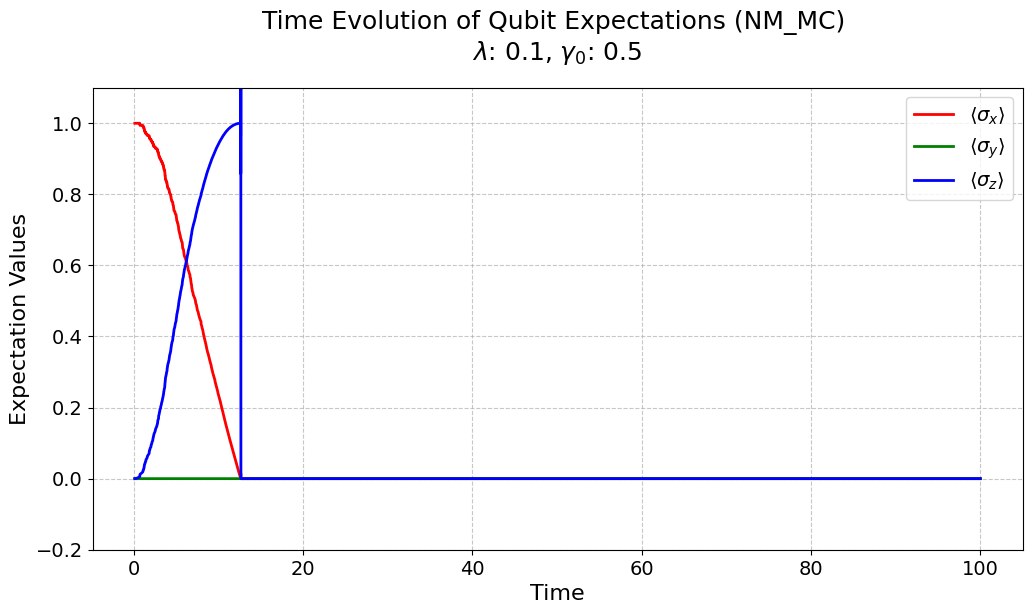

In [ ]:

data = result2#mcsolve([[H0,s]], psi0, times, c_ops, e_ops, options = Options(store_states =True))
# Assuming result1.times and result1.expect are available

fig, ax = plt.subplots(figsize=(12, 6))

# Plotting the expectations with improved labels and colors
ax.plot(data.times, data.expect[0], 'r-', label=r'$\langle\sigma_x\rangle$', linewidth=2)
ax.plot(data.times, data.expect[1], 'g-', label=r'$\langle\sigma_y\rangle$', linewidth=2)
ax.plot(data.times, data.expect[2], 'b-', label=r'$\langle\sigma_z\rangle$', linewidth=2)

# Adding titles and labels with better formatting
ax.set_title(f"Time Evolution of Qubit Expectations (NM_MC) \n$\lambda$: {lam}, $\gamma_0$: {gamma_0}", fontsize=18, pad=20)#("Time Evolution of Qubit Expectations(ME)" + "lam:":lam , , fontsize=18, pad=20)
ax.set_ylabel("Expectation Values", fontsize=16)
ax.set_xlabel("Time", fontsize=16)

# Adding a legend with improved positioning and font size
ax.legend(fontsize=14, loc='upper right')

# Adjusting y-axis limits for better visibility
ax.set_ylim(-0.2, 1.1)

# Adding a grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Adjusting tick parameters for better readability
ax.tick_params(axis='both', which='major', labelsize=14)

# Display the plot
plt.show()
